In [15]:
# Nguyen Hai Duong
# nhduong_3010@live.com
# Chonnam National University
# 2018.04.15

# Overview
### Data augmentation + EarlyStopping to avoid overfitting
- FER2013 dataset (face images + facial expression)
  + Goal: classifying facial exprression
  + Input: a 48x48 image
  + Output: facial expression (angry, disgust, fear, happy, neutral, sad, and surprise)
- Defining an CNN+MLP
- Training and evaluating an CNN+MLP

# Import libraries

In [16]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from IPython.display import Image
from keras.utils import plot_model

import time
import numpy as np
import matplotlib.pyplot as plt

In [17]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

# (1) Data

### Download data at https://drive.google.com/drive/folders/15EozdYlGeO3d-ny8nbqFM3ojTGsj2hdE?usp=sharing
This source code and npy files MUST be in the same location

In [18]:
data_path = '/kaggle/input/emoreg/'
trainingset = np.loadtxt(data_path + 'fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt(data_path + 'fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [19]:
n_inputs = 2304
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
x_training = np.expand_dims(x_training, axis=3)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=3)

# (2) Declare model

In [20]:
# 64x64 portray image
input_image = Input(shape=(48, 48, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.25, name='conv_dropout1')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_2')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_4')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.25, name='conv_dropout2')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5, name='fc_dropout1')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_7ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='emo_cnn')

# print model summary
model.summary()

Model: "emo_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 46, 46, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout1 (Dropout)              │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 23, 23, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 21, 21, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_3 (Conv2D)                     │ (None, 21, 21, 218)         │         251,354 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_4 (Conv2D)                     │ (None, 19, 19, 218)         │         427,934 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 9, 9, 218)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout2 (Dropout)              │ (None, 9, 9, 218)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 17658)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 1024)                │      18,082,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_dropout1 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3_7ways_softmax (Dense)            │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,028,287 (72.59 MB)

 Trainable params: 19,028,287 (72.59 MB)

 Non-trainable params: 0 (0.00 B)

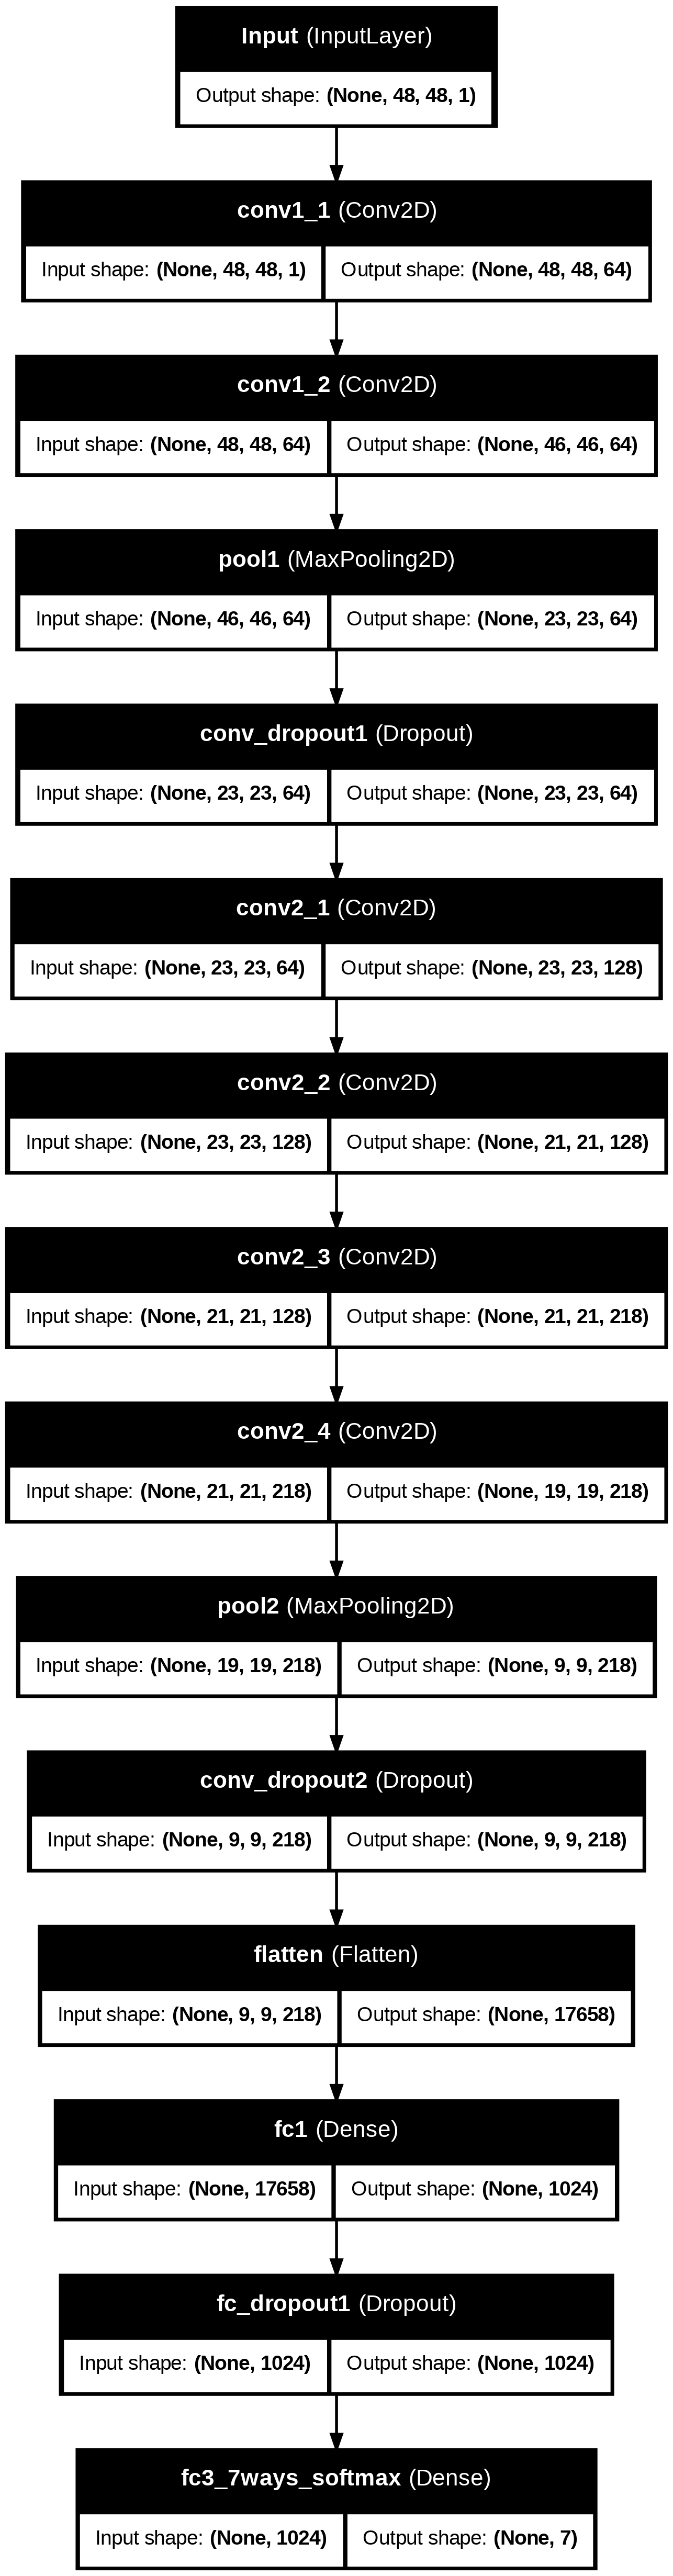

In [21]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

Image('model.png', width = 400)

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [22]:
# Data augmentation
# based on https://keras.io/preprocessing/image/
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [26]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.0001
model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

# EarlyStopping: stop training early to avoid overfitting
early_stopping_after_epochs = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_after_epochs)

# train the model
batch_size = 128
epochs = 100

starting_time = time.time()
history = model.fit(datagen.flow(x_training, y_training, batch_size=batch_size),
                              steps_per_epoch=len(x_training) // batch_size,
                              validation_data=(x_testing, y_testing),
                              epochs=epochs,
                              callbacks=[early_stopping])
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - accuracy: 0.4779 - loss: 1.3638 - val_accuracy: 0.5408 - val_loss: 1.2070
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4141 - loss: 1.3970 - val_accuracy: 0.5386 - val_loss: 1.2060
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.4960 - loss: 1.3237 - val_accuracy: 0.5394 - val_loss: 1.2026
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5469 - loss: 1.1965 - val_accuracy: 0.5433 - val_loss: 1.1982
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.4988 - loss: 1.3174 - val_accuracy: 0.5517 - val_loss: 1.1837
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4844 - loss: 1.3374 - val_accuracy: 0.5506 - val_loss: 1.1829
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.5016 - loss: 1.3041 - val_accuracy: 0.5442 - val_loss: 1.1982
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3984 - loss: 1.3707 -

### Training time
- Training time with GTX 1080 is about 22.7489 minutes for 57 epochs. The accuracy +2% without overfitting!
- Training time with Core i7 is around ??? minutes for ??? epochs

### Training time again
Training time with GPU is about 5.3195 minutes for 28 epochs. 

# (4) Evaluate trained model

In [27]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5844 - loss: 1.1067
Test loss: 1.0907227993011475
Test accuracy: 0.5831707715988159


In [28]:
def get_emotion(ohv):
    indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


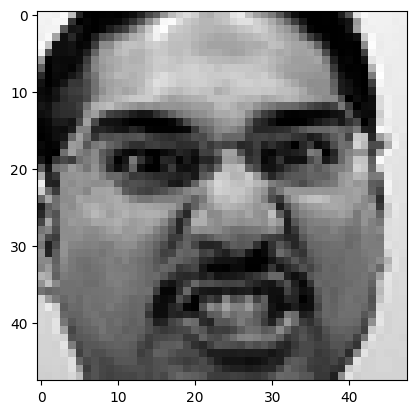

> testing image index: 2000
> true emotion: angry
> predicted emotion: angry


In [29]:
# 2163
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))